![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [ ]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

ultimo_mes = df['data_ref'].max()

safras_oot = pd.date_range(end=ultimo_mes, periods=3, freq='M')

df_oot = df[df['data_ref'].isin(safras_oot)]

df_train = df[~df['data_ref'].isin(safras_oot)]

df_train.head(), df_oot.head()

(    data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
 0 2015-01-01   5733    F                N               N           0   
 1 2015-01-01    727    F                S               S           0   
 2 2015-01-01   6374    F                N               N           2   
 3 2015-01-01   9566    F                N               N           0   
 4 2015-01-01   9502    F                S               N           0   
 
     tipo_renda             educacao estado_civil tipo_residencia  idade  \
 0   Empresário                Médio     Solteiro            Casa     43   
 1  Assalariado                Médio       Casado            Casa     35   
 2  Assalariado                Médio       Casado            Casa     31   
 3  Assalariado                Médio       Casado            Casa     54   
 4  Assalariado  Superior incompleto     Solteiro            Casa     31   
 
    tempo_emprego  qt_pessoas_residencia     renda    mau  
 0       6.873973                   

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [ ]:
num_linhas_total = df.shape[0]

linhas_por_mes = df['data_ref'].value_counts().sort_index()

variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

desc_qualitativas = df[variaveis_qualitativas].describe(include='all')

desc_quantitativas = df[variaveis_quantitativas].describe()

num_linhas_total, linhas_por_mes, desc_qualitativas, desc_quantitativas

(750000,
 data_ref
 2015-01-01    50000
 2015-02-01    50000
 2015-03-01    50000
 2015-04-01    50000
 2015-05-01    50000
 2015-06-01    50000
 2015-07-01    50000
 2015-08-01    50000
 2015-09-01    50000
 2015-10-01    50000
 2015-11-01    50000
 2015-12-01    50000
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: count, dtype: int64,
           sexo posse_de_veiculo posse_de_imovel   tipo_renda educacao  \
 count   750000           750000          750000       750000   750000   
 unique       2                2               2            5        5   
 top          F                N               S  Assalariado    Médio   
 freq    504580           457954          503692       385740   506836   
 
        estado_civil tipo_residencia     mau  
 count        750000          750000  750000  
 unique            5               6       2  
 top          Casado            Casa   False  
 freq         526472          674294  691357  ,
           qtd_filhos         

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [ ]:
for var in variaveis_quantitativas:
    media_por_grupo = df.groupby('mau')[var].mean()
    print(f'Média de {var} por grupo de inadimplência:\n', media_por_grupo)
    print('-' * 50)

Média de qtd_filhos por grupo de inadimplência:
 mau
False    0.431739
True     0.451068
Name: qtd_filhos, dtype: float64
--------------------------------------------------
Média de idade por grupo de inadimplência:
 mau
False    43.896274
True     42.725543
Name: idade, dtype: float64
--------------------------------------------------
Média de tempo_emprego por grupo de inadimplência:
 mau
False    8.004300
True     4.695965
Name: tempo_emprego, dtype: float64
--------------------------------------------------
Média de qt_pessoas_residencia por grupo de inadimplência:
 mau
False    2.211221
True     2.224272
Name: qt_pessoas_residencia, dtype: float64
--------------------------------------------------
Média de renda por grupo de inadimplência:
 mau
False    24804.689618
True      4774.871007
Name: renda, dtype: float64
--------------------------------------------------


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [ ]:
missing_values = df.isnull().sum()
print("Valores missing por coluna:\n", missing_values)

Valores missing por coluna:
 data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64


In [ ]:
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [ ]:
Q1 = df[variaveis_quantitativas].quantile(0.25)
Q3 = df[variaveis_quantitativas].quantile(0.75)
IQR = Q3 - Q1

outliers = df[((df[variaveis_quantitativas] < (Q1 - 1.5 * IQR)) | (df[variaveis_quantitativas] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Número de outliers detectados: {outliers.shape[0]}")

for var in variaveis_quantitativas:
    lower_bound = df[var].quantile(0.05)
    upper_bound = df[var].quantile(0.95)
    df[var] = df[var].clip(lower=lower_bound, upper=upper_bound)

Número de outliers detectados: 106876


In [ ]:
df['tempo_emprego'] = df['tempo_emprego'].replace(0, df['tempo_emprego'].median())

In [ ]:
df['educacao'] = df['educacao'].replace({
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior',
    'Pós-graduação': 'Superior'
})

df['tipo_renda'] = df['tipo_renda'].replace({
    'Servidor público': 'Assalariado',
    'Empresário': 'Empresário/Assalariado'
})

In [ ]:
X = df.drop(columns=['data_ref', 'index', 'mau'])
y = df['mau']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Relatório de classificação:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Relatório de classificação:
               precision    recall  f1-score   support

       False       0.92      1.00      0.96    207295
        True       0.00      0.00      0.00     17705

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000

AUC-ROC: 0.7751455037844794


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
X = df.drop(columns=['data_ref', 'index', 'mau'])
y = df['mau']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Relatório de classificação:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Relatório de classificação:
               precision    recall  f1-score   support

       False       0.92      1.00      0.96    207295
        True       0.00      0.00      0.00     17705

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000

AUC-ROC: 0.7751455037844794


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
coeficientes = pd.DataFrame({'Variável': X.columns, 'Coeficiente': model.coef_[0]})
print("Coeficientes do modelo:\n", coeficientes)


Coeficientes do modelo:
                              Variável  Coeficiente
0                          qtd_filhos    -0.007815
1                               idade    -0.001074
2                       tempo_emprego    -0.152392
3               qt_pessoas_residencia     0.005133
4                               renda    -2.561750
5                              sexo_M    -0.060530
6                  posse_de_veiculo_S     0.017185
7                   posse_de_imovel_S    -0.038133
8                 tipo_renda_Bolsista    -0.003051
9   tipo_renda_Empresário/Assalariado    -0.018573
10             tipo_renda_Pensionista    -0.020979
11                     educacao_Médio    -0.029881
12             educacao_Pós graduação    -0.007775
13                  educacao_Superior    -0.057023
14              estado_civil_Separado     0.014419
15              estado_civil_Solteiro     0.003353
16                 estado_civil_União     0.009116
17                 estado_civil_Viúvo    -0.012444
18    

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Acurácia na base de desenvolvimento (treino): {accuracy_train:.4f}")
print(f"Acurácia na base OOT (teste): {accuracy_test:.4f}")

Acurácia na base de desenvolvimento (treino): 0.9220
Acurácia na base OOT (teste): 0.9213


In [ ]:
def ks_statistic(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    return np.max(tpr - fpr)

ks_train = ks_statistic(y_train, y_train_prob)
ks_test = ks_statistic(y_test, y_test_prob)

print(f"KS na base de desenvolvimento (treino): {ks_train:.4f}")
print(f"KS na base OOT (teste): {ks_test:.4f}")

KS na base de desenvolvimento (treino): 0.4164
KS na base OOT (teste): 0.4132


In [ ]:
def gini_coefficient(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    return 2 * auc - 1

gini_train = gini_coefficient(y_train, y_train_prob)
gini_test = gini_coefficient(y_test, y_test_prob)

print(f"Gini na base de desenvolvimento (treino): {gini_train:.4f}")
print(f"Gini na base OOT (teste): {gini_test:.4f}")

Gini na base de desenvolvimento (treino): 0.5507
Gini na base OOT (teste): 0.5503


### O modelo apresenta métricas bastante consistentes entre a base de treino e a base OOT, sugerindo que ele não está sofrendo de overfitting.

## Criar um pipeline utilizando o sklearn pipeline

In [ ]:
X = df.drop(columns=['mau', 'data_ref', 'index'])
y = df['mau']

In [ ]:
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

ks_train = ks_statistic(y_train, y_train_prob)
ks_test = ks_statistic(y_test, y_test_prob)

gini_train = gini_coefficient(y_train, y_train_prob)
gini_test = gini_coefficient(y_test, y_test_prob)

print(f"Acurácia na base de desenvolvimento (treino): {accuracy_train:.4f}")
print(f"Acurácia na base OOT (teste): {accuracy_test:.4f}")
print(f"KS na base de desenvolvimento (treino): {ks_train:.4f}")
print(f"KS na base OOT (teste): {ks_test:.4f}")
print(f"Gini na base de desenvolvimento (treino): {gini_train:.4f}")
print(f"Gini na base OOT (teste): {gini_test:.4f}")


Acurácia na base de desenvolvimento (treino): 0.9220
Acurácia na base OOT (teste): 0.9213
KS na base de desenvolvimento (treino): 0.4160
KS na base OOT (teste): 0.4127
Gini na base de desenvolvimento (treino): 0.5506
Gini na base OOT (teste): 0.5498


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [ ]:
nulos_por_coluna = df.isnull().sum()
print(nulos_por_coluna)

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [ ]:
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print(df.isnull().sum())

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [ ]:
print(df.isnull().sum().sum())

0


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [ ]:
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['renda'] < limite_inferior) | (df['renda'] > limite_superior)]
print(f"Número de outliers na variável 'renda': {outliers.shape[0]}")

df_sem_outliers = df[(df['renda'] >= limite_inferior) & (df['renda'] <= limite_superior)]


Número de outliers na variável 'renda': 79072


In [ ]:
df['renda'] = np.where(df['renda'] < limite_inferior, limite_inferior, df['renda'])
df['renda'] = np.where(df['renda'] > limite_superior, limite_superior, df['renda'])

Como os outliers encontrados na variável "renda" foram muito altos, eu optei pela substituição pelos limites.

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', numeric_imputer)]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('onehot', OneHotEncoder(drop='first'))]), categorical_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


In [ ]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)

boruta_selector.fit(X_train_transformed, y_train)

selected_features = feature_names[boruta_selector.support_].tolist()
print("Variáveis selecionadas pelo Boruta:", selected_features)

Variáveis selecionadas pelo Boruta: ['num__renda']


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=5))
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first'))
        ]), categorical_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [ ]:
categorical_cols = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

df_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(df_dummies.head())


    data_ref  index  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
0 2015-01-01   5733           0     43       6.873973                    1.0   
1 2015-01-01    727           0     35       4.526027                    2.0   
2 2015-01-01   6374           2     31       0.816438                    4.0   
3 2015-01-01   9566           0     54      12.772603                    2.0   
4 2015-01-01   9502           0     31       8.432877                    1.0   

      renda    mau  sexo_M  posse_de_veiculo_S  ...  educacao_Superior  \
0   2515.39  False   False               False  ...              False   
1   3180.19  False   False                True  ...              False   
2   1582.29  False   False               False  ...              False   
3  13721.17  False   False               False  ...              False   
4   2891.08  False   False                True  ...               True   

   estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0  

In [ ]:
categorical_cols = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

encoder = OneHotEncoder(drop='first')

encoded_data = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

df_encoded = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

print(df_encoded.head())

    data_ref  index  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
0 2015-01-01   5733           0     43       6.873973                    1.0   
1 2015-01-01    727           0     35       4.526027                    2.0   
2 2015-01-01   6374           2     31       0.816438                    4.0   
3 2015-01-01   9566           0     54      12.772603                    2.0   
4 2015-01-01   9502           0     31       8.432877                    1.0   

      renda    mau  sexo_M  posse_de_veiculo_S  ...  educacao_Superior  \
0   2515.39  False     0.0                 0.0  ...                0.0   
1   3180.19  False     0.0                 1.0  ...                0.0   
2   1582.29  False     0.0                 0.0  ...                0.0   
3  13721.17  False     0.0                 0.0  ...                0.0   
4   2891.08  False     0.0                 1.0  ...                1.0   

   estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0  

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        z_scores = np.abs((X - X.mean()) / X.std())
        X_outlier_removed = X[(z_scores < self.threshold).all(axis=1)]
        return X_outlier_removed

categorical_cols = ['posse_de_veiculo']
numeric_cols = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

X_numeric = df[numeric_cols]
X_categorical = df[categorical_cols]

X_numeric_cleaned = OutlierRemover().fit_transform(X_numeric)

X_numeric_transformed = numeric_pipeline.fit_transform(X_numeric_cleaned)

X_categorical_transformed = categorical_pipeline.fit_transform(X_categorical)

if X_numeric_cleaned.shape[0] != X_categorical.shape[0]:
    raise ValueError("Número de linhas após a remoção de outliers não coincide com as variáveis categóricas")

df_transformed = np.hstack([X_numeric_transformed, X_categorical_transformed])

numeric_column_names = [f'PC{i+1}' for i in range(X_numeric_transformed.shape[1])]
categorical_column_names = categorical_pipeline.named_steps['onehot'].get_feature_names_out()

print(f"Number of columns in transformed data: {df_transformed.shape[1]}")
print(f"Expected number of columns: {len(numeric_column_names) + len(categorical_column_names)}")

column_names = numeric_column_names + list(categorical_column_names)

df_transformed = pd.DataFrame(df_transformed, columns=column_names)

print(df_transformed.head())


Number of columns in transformed data: 6
Expected number of columns: 6
        PC1       PC2       PC3       PC4       PC5  x0_S
0 -1.058970 -1.024961 -0.481099 -0.606251  0.538596   0.0
1  0.046827 -1.092688 -0.755905 -0.291679 -0.313192   1.0
2  3.613326 -0.600146  0.471185  0.265832  0.145687   0.0
3 -1.130589  0.659741  0.546949 -0.662889 -0.237763   0.0
4 -0.637531 -0.859220 -1.467669 -0.934974  0.498093   1.0


### Treinar um modelo de regressão logistica com o resultado

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        z_scores = np.abs((X - X.mean()) / X.std())
        X_outlier_removed = X[(z_scores < self.threshold).all(axis=1)]
        return X_outlier_removed

categorical_cols = ['posse_de_veiculo']
numeric_cols = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

print("Colunas do DataFrame:", df.columns)

df_with_target = df.copy()

df_with_target['target'] = df_with_target['mau']

print("Colunas do DataFrame com alvo:", df_with_target.columns)

X = df_with_target.drop(['mau', 'target'], axis=1)
y = df_with_target['target']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)


Colunas do DataFrame: Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')
Colunas do DataFrame com alvo: Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'target'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    207295
        True       0.00      0.00      0.00     17705

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Salvar o pickle file do modelo treinado

In [ ]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

# Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [ ]:
from pycaret.classification import *

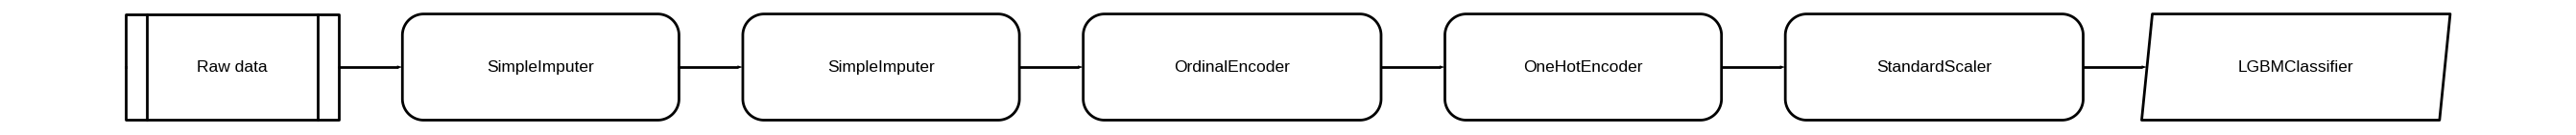

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 Tra...
                                    transformer=OneHotEncoder(cols=['tipo_renda',
                  

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9220,0.7811,0.0296,0.5164,0.0560,0.0479,0.1095


    data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia         renda    mau  \
0       6.873972                    1.0   2515

In [ ]:
# Carregando o dataframe e ajustando tipos categóricos
df['sexo'] = df['sexo'].astype('category')
df['posse_de_veiculo'] = df['posse_de_veiculo'].astype('category')
df['posse_de_imovel'] = df['posse_de_imovel'].astype('category')
df['tipo_renda'] = df['tipo_renda'].astype('category')
df['educacao'] = df['educacao'].astype('category')
df['estado_civil'] = df['estado_civil'].astype('category')
df['tipo_residencia'] = df['tipo_residencia'].astype('category')

# Amostragem: usar apenas 10% dos dados para melhorar a performance
df_sample = df.sample(frac=0.1, random_state=42)

# Configuração do PyCaret com melhorias de performance
clf = setup(data=df_sample,
            target='mau',
            categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
            numeric_features=['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
            ignore_features=['data_ref', 'index'],
            session_id=42,
            normalize=True,
            remove_outliers=False,  # Não remover outliers para melhorar a performance
            feature_selection=False,  # Desativar a seleção de variáveis para melhorar o tempo
            verbose=False)  # Reduzir a saída

# Comparar apenas alguns modelos para melhorar a performance
best_model = compare_models(include=['lightgbm', 'rf', 'xgboost'], n_select=1)

# Criar e treinar o modelo LightGBM
lgbm_model = create_model('lightgbm')

# Avaliar o modelo
evaluate_model(lgbm_model)

# Finalizar o modelo
final_model = finalize_model(lgbm_model)

# Obter o pipeline treinado
pipeline = get_config('pipeline')
print(pipeline)

new_data = pd.read_feather('credit_scoring.ftr')
predictions = predict_model(final_model, data=new_data)

# Exibir as primeiras previsões
print(predictions.head())


### Salvar o arquivo do modelo treinado

In [ ]:
# Salvando o modelo treinado
save_model(final_model, 'modelo_treinado')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit
    - Subir um csv no streamlit
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos.
1. Enviar links do github para o tutor corrigir.